# Data Exploration: SCADA Wind Turbine Data

This notebook explores the SCADA dataset to understand:
- Data structure and features
- Missing values and data quality
- Sampling frequency
- Feature distributions
- Correlation with power output
- Wind speed vs power curve visualization


In [27]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

# Add src to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root / 'src'))

# Force reload modules to ensure latest version
import data_loader
import preprocessing
importlib.reload(data_loader)
importlib.reload(preprocessing)

# Import after reload
from data_loader import load_scada_data, get_feature_info, identify_target_features
from preprocessing import clean_scada_data

# Verify the fix is loaded
import inspect
preprocessing_source = inspect.getsource(preprocessing.clean_scada_data)
if 'fillna(method=' in preprocessing_source:
    print("⚠️  WARNING: Old version detected. Please restart kernel!")
else:
    print("✅ Preprocessing module loaded correctly")

# Ensure results directories exist
(project_root / 'results' / 'figures').mkdir(parents=True, exist_ok=True)
(project_root / 'results' / 'metrics').mkdir(parents=True, exist_ok=True)
(project_root / 'data' / 'processed').mkdir(parents=True, exist_ok=True)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


✅ Preprocessing module loaded correctly


## Load Data


In [28]:
# Load SCADA data
csv_path = project_root / 'data' / 'raw' / 'Aventa_AV7_IET_OST_SCADA.csv'
print(f"Loading data from: {csv_path}")

# Load with chunking for large files
# For very large files, you can use:
# - chunksize=100000 to load in chunks
# - max_rows=1000000 to limit total rows
# - sample_ratio=0.1 to randomly sample 10% of data
try:
    df = load_scada_data(str(csv_path), chunksize=100000)
except MemoryError:
    print("Memory error. Trying with smaller chunksize...")
    df = load_scada_data(str(csv_path), chunksize=50000)
except Exception as e:
    print(f"Error: {e}")
    print("Trying with max_rows limit...")
    df = load_scada_data(str(csv_path), chunksize=50000, max_rows=2000000)

print(f"\nData loaded: {len(df)} rows, {len(df.columns)} columns")
print(f"\nFirst few rows:")
df.head()


Loading data from: D:\mini project\data\raw\Aventa_AV7_IET_OST_SCADA.csv


Loading data in chunks of 100000 rows...
  Loaded 10 chunks (1,000,000 rows)...
  Loaded 20 chunks (2,000,000 rows)...
  Loaded 30 chunks (3,000,000 rows)...
  Loaded 40 chunks (4,000,000 rows)...
  Loaded 50 chunks (5,000,000 rows)...
  Loaded 60 chunks (6,000,000 rows)...
  Loaded 70 chunks (7,000,000 rows)...
  Loaded 80 chunks (8,000,000 rows)...
  Loaded 90 chunks (9,000,000 rows)...
  Loaded 100 chunks (10,000,000 rows)...
  Loaded 110 chunks (11,000,000 rows)...
  Loaded 120 chunks (12,000,000 rows)...
  Loaded 130 chunks (13,000,000 rows)...
  Loaded 140 chunks (14,000,000 rows)...
  Loaded 150 chunks (15,000,000 rows)...
  Loaded 160 chunks (16,000,000 rows)...
  Loaded 170 chunks (17,000,000 rows)...
  Loaded 180 chunks (18,000,000 rows)...
  Loaded 190 chunks (19,000,000 rows)...
  Loaded 200 chunks (20,000,000 rows)...
  Loaded 210 chunks (21,000,000 rows)...
  Loaded 220 chunks (22,000,000 rows)...
  Loaded 230 chunks (23,000,000 rows)...
  Loaded 240 chunks (24,000,000 ro

,Datetime,RotorSpeed,GeneratorSpeed,GeneratorTemperature,WindSpeed,PowerOutput,SpeiseSpannung,StatusAnlage,MaxWindHeute,offsetWindDirection,PitchDeg
0,2021-12-31 23:00:00.647,0.0,0.0,11.6,0.0,0.0,27.8,13.0,0.0,21.0,80.313994
1,2021-12-31 23:00:01.647,0.0,0.0,11.6,0.0,0.0,27.8,13.0,0.0,13.0,80.313994
2,2021-12-31 23:00:02.647,0.0,0.0,11.6,0.0,0.0,27.8,13.0,0.0,12.0,80.313994
3,2021-12-31 23:00:03.650,0.0,0.0,11.6,0.0,0.0,27.8,13.0,0.0,12.0,80.313994
4,2021-12-31 23:00:04.650,0.0,0.0,11.6,0.0,0.0,27.8,13.0,0.0,12.0,80.313994


In [29]:
# Get feature information
info = get_feature_info(df)
print("Dataset Information:")
print(f"  Samples: {info['n_samples']:,}")
print(f"  Features: {info['n_features']}")
print(f"  Sampling frequency: {info.get('sampling_frequency', 'N/A')}")
print(f"\nColumn names:")
print(df.columns.tolist())


Dataset Information:
  Samples: 39,715,978
  Features: 11
  Sampling frequency: N/A

Column names:
['Datetime', 'RotorSpeed', 'GeneratorSpeed', 'GeneratorTemperature', 'WindSpeed', 'PowerOutput', 'SpeiseSpannung', 'StatusAnlage', 'MaxWindHeute', 'offsetWindDirection', 'PitchDeg']


## Identify Key Features


In [30]:
# Identify target features
features = identify_target_features(df)
print("Identified Features:")
for feature_type, col_name in features.items():
    if col_name:
        print(f"  {feature_type}: {col_name}")
    else:
        print(f"  {feature_type}: NOT FOUND")

# If auto-detection fails, manually specify based on actual column names
if not features['power']:
    print("\n⚠️  Power column not auto-detected. Please check column names above and update manually.")


Identified Features:
  wind_speed: WindSpeed
  wind_direction: offsetWindDirection
  power: PowerOutput
  temperature: GeneratorTemperature
  rotor_speed: RotorSpeed
  pitch_angle: PitchDeg


## Missing Values Analysis


Missing Values Summary:
          Column  Missing %
8   MaxWindHeute   0.000005
4      WindSpeed   0.000003
10      PitchDeg   0.000003
5    PowerOutput   0.000003


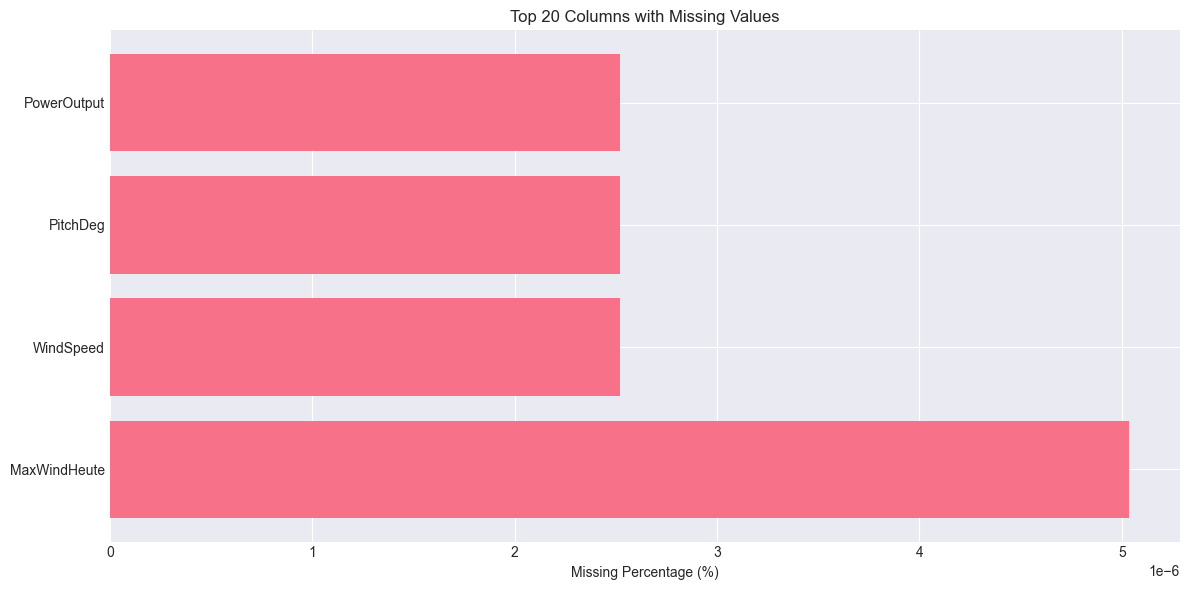

In [31]:
# Missing values analysis
missing_pct = info['missing_pct']
missing_df = pd.DataFrame({
    'Column': list(missing_pct.keys()),
    'Missing %': list(missing_pct.values())
}).sort_values('Missing %', ascending=False)

print("Missing Values Summary:")
print(missing_df[missing_df['Missing %'] > 0])

# Visualize missing values
if len(missing_df[missing_df['Missing %'] > 0]) > 0:
    # Ensure directory exists
    figures_dir = project_root / 'results' / 'figures'
    figures_dir.mkdir(parents=True, exist_ok=True)
    
    plt.figure(figsize=(12, 6))
    missing_df_top = missing_df[missing_df['Missing %'] > 0].head(20)
    plt.barh(range(len(missing_df_top)), missing_df_top['Missing %'])
    plt.yticks(range(len(missing_df_top)), missing_df_top['Column'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 20 Columns with Missing Values')
    plt.tight_layout()
    plt.savefig(figures_dir / 'missing_values.png', dpi=150)
    plt.show()


## Feature Distributions


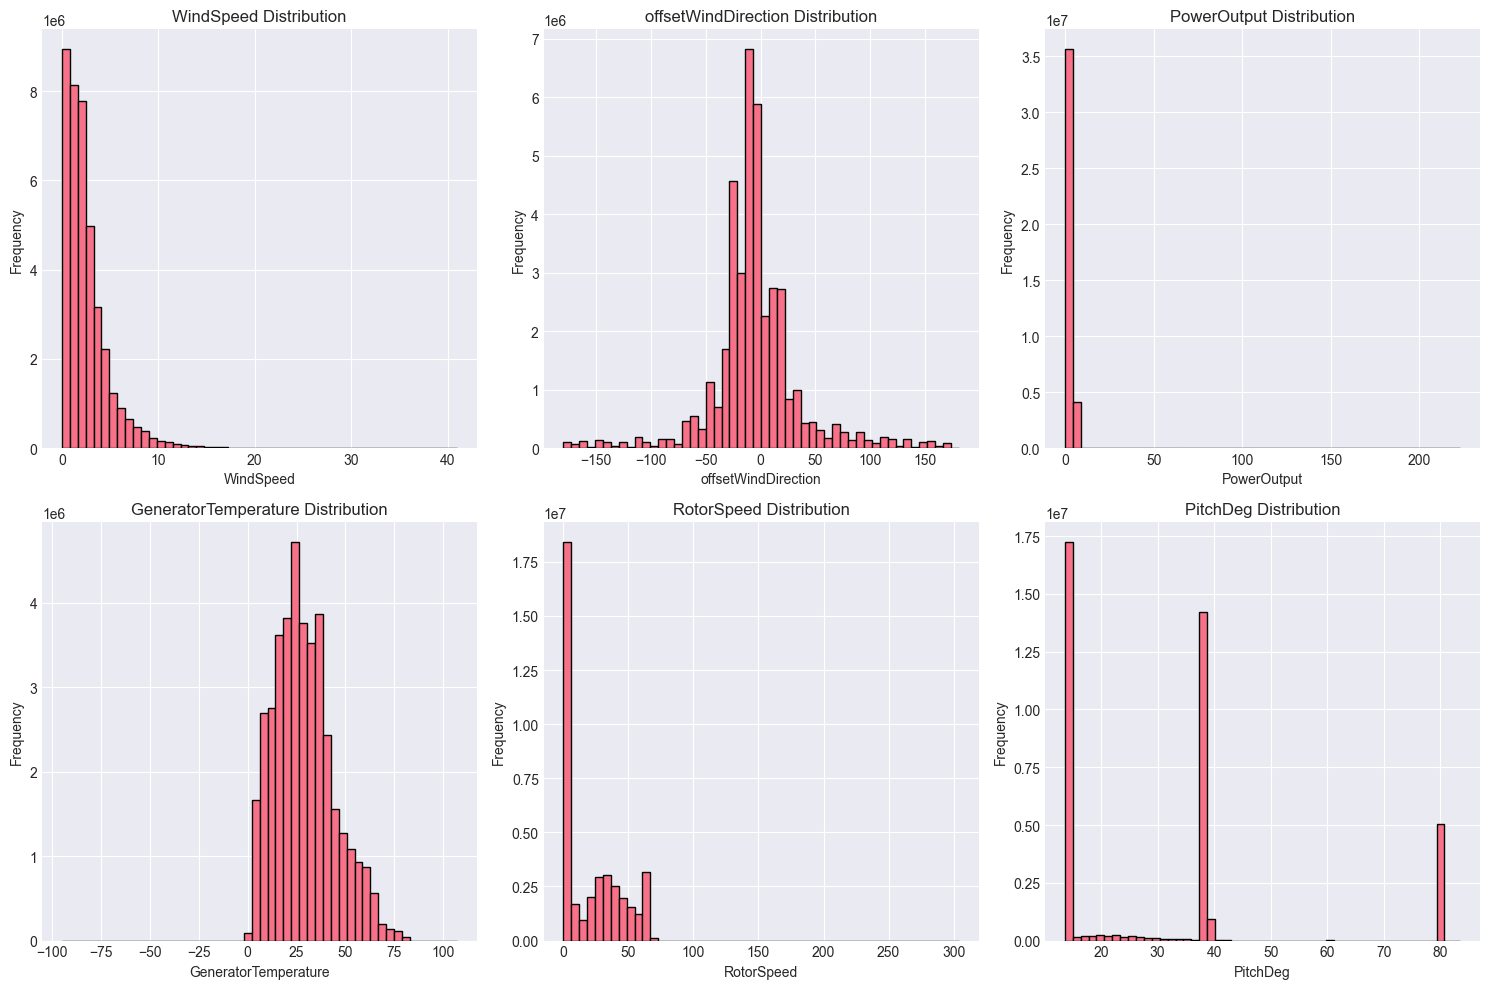


Summary Statistics for Key Features:
          WindSpeed  offsetWindDirection   PowerOutput  GeneratorTemperature  \
count  3.971598e+07         3.971598e+07  3.971598e+07          3.971598e+07   
mean   2.457526e+00        -5.174433e+00  1.051422e+00          2.871725e+01   
std    2.324517e+00         4.173172e+01  1.957080e+00          1.532112e+01   
min    0.000000e+00        -1.800000e+02 -2.200000e-01         -9.510000e+01   
25%    1.000000e+00        -2.300000e+01  0.000000e+00          1.740000e+01   
50%    1.900000e+00        -8.000000e+00  0.000000e+00          2.680000e+01   
75%    3.200000e+00         9.000000e+00  1.050000e+00          3.820000e+01   
max    4.100000e+01         1.810000e+02  2.230000e+02          1.073000e+02   

         RotorSpeed      PitchDeg  
count  3.971598e+07  3.971598e+07  
mean   2.067616e+01  3.227648e+01  
std    2.260638e+01  2.142140e+01  
min    0.000000e+00  1.360799e+01  
25%    0.000000e+00  1.403400e+01  
50%    1.060000e+01  3.78

In [32]:
# Select key features for analysis
key_features = [f for f in features.values() if f and f in df.columns]
if len(key_features) > 0:
    # Plot distributions
    n_features = len(key_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_features == 1 else axes
    
    for i, feat in enumerate(key_features):
        if i < len(axes):
            df[feat].hist(bins=50, ax=axes[i], edgecolor='black')
            axes[i].set_title(f'{feat} Distribution')
            axes[i].set_xlabel(feat)
            axes[i].set_ylabel('Frequency')
    
    # Hide unused subplots
    for i in range(len(key_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'figures' / 'feature_distributions.png', dpi=150)
    plt.show()
    
    # Summary statistics
    print("\nSummary Statistics for Key Features:")
    print(df[key_features].describe())


## Correlation Analysis


Correlation with Power Output:
PowerOutput             1.000000
RotorSpeed              0.858254
GeneratorSpeed          0.838689
GeneratorTemperature    0.710381
WindSpeed               0.616794
MaxWindHeute            0.404237
StatusAnlage            0.012207
SpeiseSpannung         -0.012502
offsetWindDirection    -0.016561
PitchDeg               -0.367117
Name: PowerOutput, dtype: float64


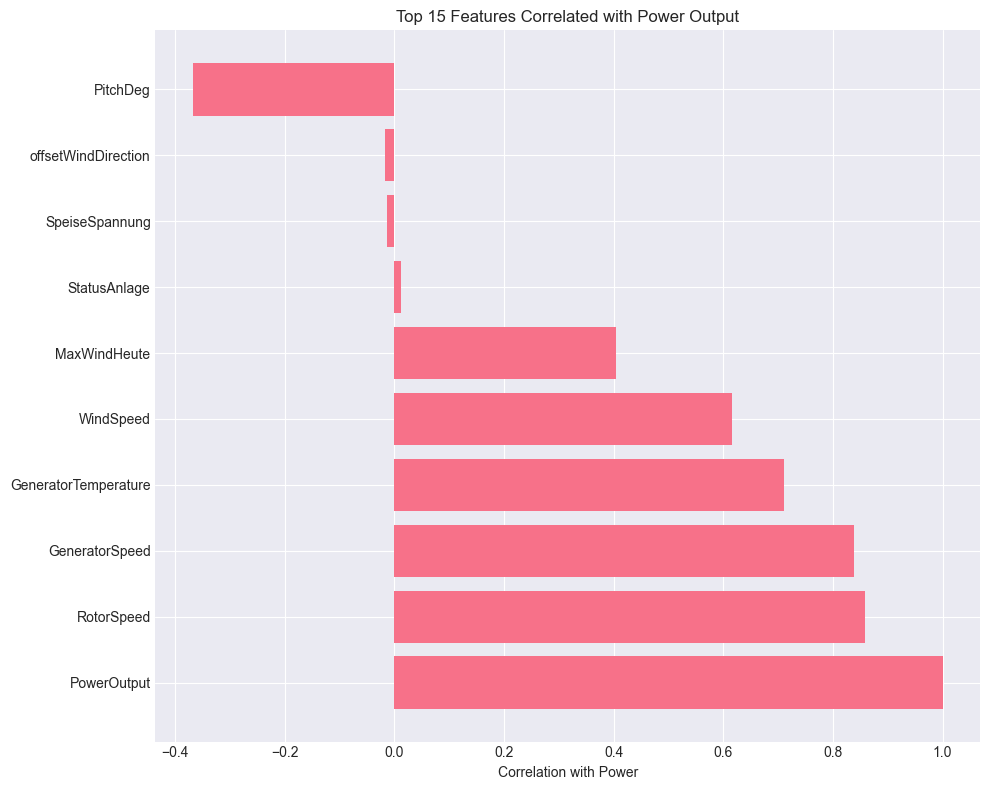

In [33]:
# Correlation with power output
if features['power'] and features['power'] in df.columns:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlations = df[numeric_cols].corr()[features['power']].sort_values(ascending=False)
    
    print("Correlation with Power Output:")
    print(correlations.head(20))
    
    # Visualize correlation
    plt.figure(figsize=(10, 8))
    top_corr = correlations.head(15)
    plt.barh(range(len(top_corr)), top_corr.values)
    plt.yticks(range(len(top_corr)), top_corr.index)
    plt.xlabel('Correlation with Power')
    plt.title('Top 15 Features Correlated with Power Output')
    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'figures' / 'correlation_with_power.png', dpi=150)
    plt.show()


## Wind Speed vs Power Curve


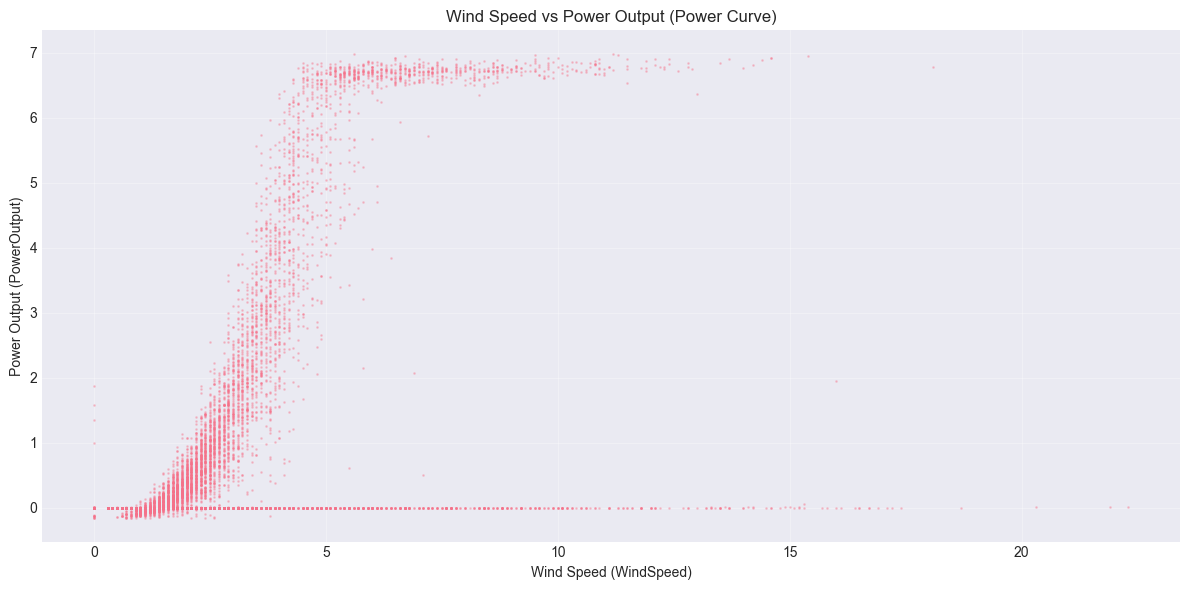

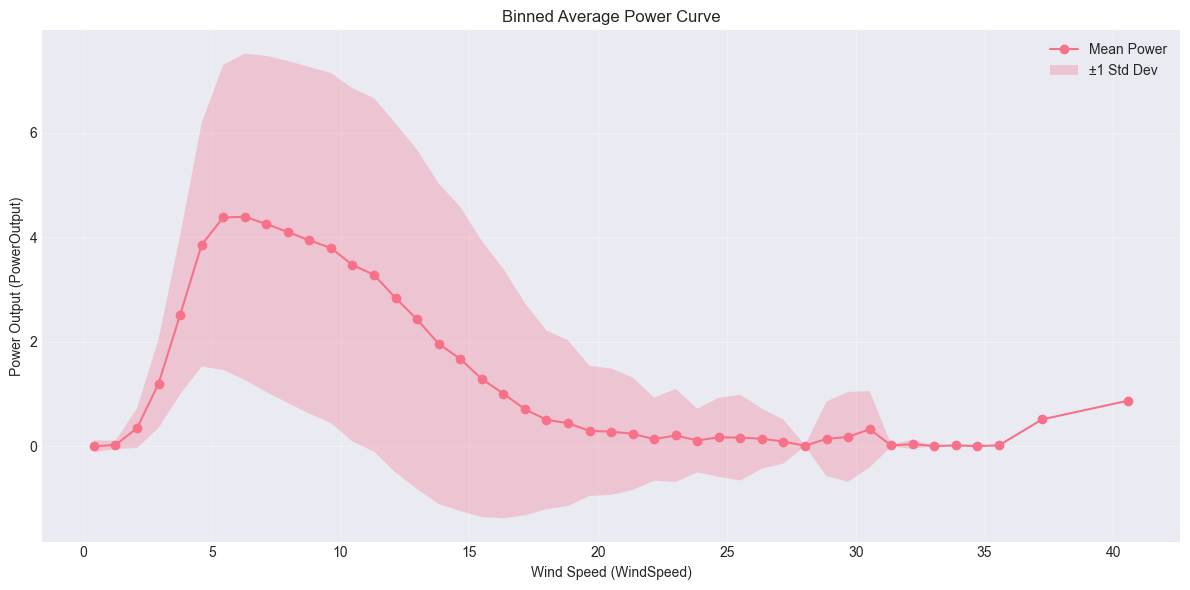

In [34]:
# Wind speed vs power curve
if features['wind_speed'] and features['power']:
    ws_col = features['wind_speed']
    power_col = features['power']
    
    # Sample data for visualization if too large
    sample_size = min(10000, len(df))
    df_sample = df.sample(n=sample_size, random_state=42) if len(df) > sample_size else df
    
    plt.figure(figsize=(12, 6))
    plt.scatter(df_sample[ws_col], df_sample[power_col], alpha=0.3, s=1)
    plt.xlabel(f'Wind Speed ({ws_col})')
    plt.ylabel(f'Power Output ({power_col})')
    plt.title('Wind Speed vs Power Output (Power Curve)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'figures' / 'power_curve.png', dpi=150)
    plt.show()
    
    # Binned average for clearer curve
    if len(df) > 1000:
        bins = np.linspace(df[ws_col].min(), df[ws_col].max(), 50)
        df['ws_bin'] = pd.cut(df[ws_col], bins=bins)
        binned = df.groupby('ws_bin')[power_col].agg(['mean', 'std', 'count'])
        binned['ws_center'] = [interval.mid for interval in binned.index]
        
        plt.figure(figsize=(12, 6))
        plt.plot(binned['ws_center'], binned['mean'], 'o-', label='Mean Power')
        plt.fill_between(
            binned['ws_center'],
            binned['mean'] - binned['std'],
            binned['mean'] + binned['std'],
            alpha=0.3,
            label='±1 Std Dev'
        )
        plt.xlabel(f'Wind Speed ({ws_col})')
        plt.ylabel(f'Power Output ({power_col})')
        plt.title('Binned Average Power Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(project_root / 'results' / 'figures' / 'power_curve_binned.png', dpi=150)
        plt.show()


## Time Series Visualization


In [35]:
# Time series plots
if isinstance(df.index, pd.DatetimeIndex) and features['power']:
    # Sample time period for visualization
    if len(df) > 10000:
        # Take first 10000 points or a week's worth
        df_ts = df.iloc[:10000] if len(df) > 10000 else df
    else:
        df_ts = df
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
    
    if features['power']:
        axes[0].plot(df_ts.index, df_ts[features['power']], linewidth=0.5)
        axes[0].set_ylabel('Power Output')
        axes[0].set_title('Power Output Time Series')
        axes[0].grid(True, alpha=0.3)
    
    if features['wind_speed']:
        axes[1].plot(df_ts.index, df_ts[features['wind_speed']], linewidth=0.5, color='orange')
        axes[1].set_ylabel('Wind Speed')
        axes[1].set_title('Wind Speed Time Series')
        axes[1].grid(True, alpha=0.3)
    
    if features['wind_direction']:
        axes[2].plot(df_ts.index, df_ts[features['wind_direction']], linewidth=0.5, color='green')
        axes[2].set_ylabel('Wind Direction')
        axes[2].set_xlabel('Time')
        axes[2].set_title('Wind Direction Time Series')
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'figures' / 'time_series.png', dpi=150)
    plt.show()


## Clean and Save Processed Data


In [36]:
# Clean data and save to processed folder
if all([features['power'], features['wind_speed']]):
    # Select feature columns (use all numeric columns or specify)
    feature_cols = [f for f in features.values() if f and f in df.columns and f != features['power']]
    
    # Add other numeric columns if available
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    additional_features = [col for col in numeric_cols if col not in feature_cols and col != features['power']]
    feature_cols.extend(additional_features[:10])  # Limit to avoid too many features
    
    print(f"Cleaning data with {len(feature_cols)} features...")
    print(f"Original data: {len(df):,} rows")
    
    # For very large datasets, consider sampling or processing in chunks
    if len(df) > 10_000_000:
        print("⚠️  Large dataset detected. Cleaning may take a while...")
        print("   Consider using sample_ratio in load_scada_data() for faster processing.")
    
    df_clean = clean_scada_data(
        df,
        target_col=features['power'],
        feature_cols=feature_cols,
        remove_outliers=True,
        fill_method='interpolate'
    )
    
    print(f"Cleaned data: {len(df_clean):,} rows ({len(df_clean)/len(df)*100:.1f}% of original)")
    print(f"Features: {df_clean.columns.tolist()}")
    
    # Save cleaned data
    output_path = project_root / 'data' / 'processed' / 'scada_cleaned.csv'
    print(f"\nSaving cleaned data to {output_path}...")
    print("   (This may take several minutes for large datasets)")
    
    # Use compression for large files to save disk space
    if len(df_clean) > 1_000_000:
        output_path = output_path.with_suffix('.csv.gz')
        df_clean.to_csv(output_path, index=True, compression='gzip')
        print(f"✅ Cleaned data saved (compressed) to: {output_path}")
    else:
        df_clean.to_csv(output_path, index=True)
        print(f"✅ Cleaned data saved to: {output_path}")
    
    # Save feature mapping
    import json
    feature_mapping = {
        'target': features['power'],
        'features': feature_cols,
        'all_features': features
    }
    mapping_path = project_root / 'data' / 'processed' / 'feature_mapping.json'
    with open(mapping_path, 'w') as f:
        json.dump(feature_mapping, f, indent=2)
    print(f"✅ Feature mapping saved to: {mapping_path}")
else:
    print("⚠️  Cannot clean data: missing required features (power or wind_speed)")


Cleaning data with 9 features...
Original data: 39,715,978 rows
⚠️  Large dataset detected. Cleaning may take a while...
   Consider using sample_ratio in load_scada_data() for faster processing.
Cleaned data: 37,244,084 rows (93.8% of original)
Features: ['PowerOutput', 'WindSpeed', 'offsetWindDirection', 'GeneratorTemperature', 'RotorSpeed', 'PitchDeg', 'GeneratorSpeed', 'SpeiseSpannung', 'StatusAnlage', 'MaxWindHeute']

Saving cleaned data to D:\mini project\data\processed\scada_cleaned.csv...
   (This may take several minutes for large datasets)
✅ Cleaned data saved (compressed) to: D:\mini project\data\processed\scada_cleaned.csv.gz
✅ Feature mapping saved to: D:\mini project\data\processed\feature_mapping.json
